In [1]:
from pathlib import Path
import json

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

from scipy.stats import lognorm

from astropy import stats
from astropy.time import Time, TimezoneInfo
import astropy.units as u
from astropy.visualization import time_support, hist
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, TETE
from astropy.io import ascii

from photutils.aperture import ApertureStats

from timdimm_tng.ser import load_ser_file
from timdimm_tng.analyze_cube import find_apertures, analyze_dimm_cube, timdimm_seeing

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x31325c380>

In [2]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget

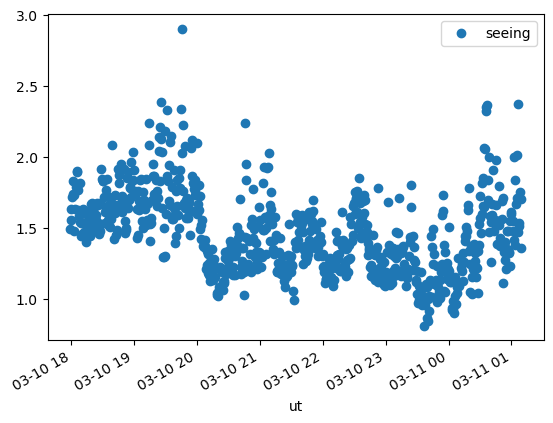

In [3]:
df = pd.read_csv(Path.home() / "SAAO" / "seeing.csv").dropna(how='any')
df = df[df['seeing'] < 10]
df = df[df['seeing'] > 0.3]
df = df.set_index(pd.DatetimeIndex(df['time'], name='ut'))
lastday = df.loc[df.index > (df.index[-1] - pd.Timedelta(14, 'h'))]
feb22 = lastday.plot(y='seeing', style='o').get_figure()
#feb22.savefig('feb22.pdf')

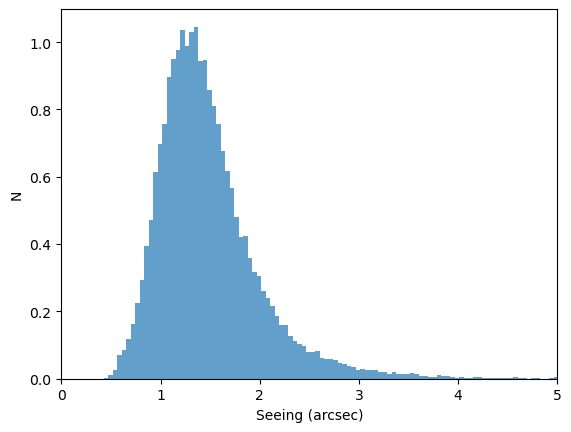

In [4]:
hist(df['seeing'][df['seeing'] < 10.0], bins='scott', histtype='stepfilled', alpha=0.7, density=True)
plt.xlim(0, 5)
plt.xlabel('Seeing (arcsec)')
plt.ylabel('N')
plt.show()

In [5]:
np.median(df['seeing'])

np.float64(1.387)

In [ ]:
df.describe()

In [ ]:
stats.sigma_clipped_stats(df['seeing'], sigma=10, maxiters=5)

In [ ]:
qe_tab = Table.read("~/MMT/timdimm_tng/notebooks/asi432mm_qe.csv", format="ascii.csv", names=["wavelength", "qe"])
np.sum(qe_tab["qe"] * qe_tab["wavelength"]) /np.sum(qe_tab["qe"])

In [ ]:
206265 * 9e-6 / 2.5

In [ ]:
plt.close('all')

In [ ]:
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-21-31.ser"
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-18-32.ser"
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-07-03/peacock.ser"
testfile = Path.home() / "find_boxes.ser"
testfile = Path.home() / "SAAO/bad4.ser"
testfile = Path.home() / "MMT/fassdimm_data/20241025/bad1.ser"
testfile = Path.home() / "MMT/fassdimm_data/bad_dec.ser"
testfile = Path.home() / "bad_20250217.ser"

#testfile = Path.home() / "SAAO/seeing_2024-04-30T04:30+02:00.ser"
#testfile = Path.home() / "SAAO/seeing_2024-05-05T01:57+02:00.ser"
#testfile = Path.home() / "SAAO/timdimm_data/indi_2023-12-08/indi_record_2023-12-08@20-48-35.ser"
#testfile = Path.home() / "SAAO/timdimm_data/indi_2024-01-20/indi_record_2024-01-20@02-33-24.ser"
d = load_ser_file(testfile)

In [ ]:
airmass = 1/np.cos(90 * u.deg - 62 * u.deg)
airmass = 1.0
results = analyze_dimm_cube(testfile, airmass=airmass, napertures=2, plot=True)
results["seeing"], results['N_bad']

(<Quantity [6.32853966, 5.64573446] pix>,
 array([2010963.64286345, 2351869.77600518]))

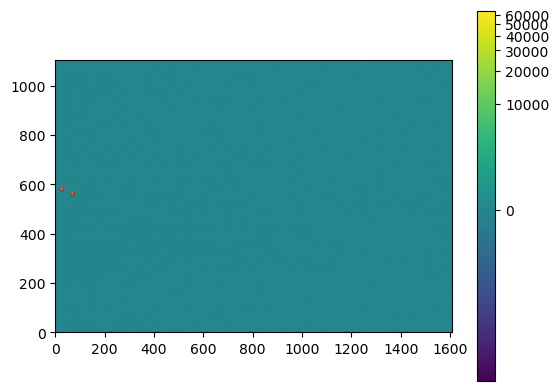

In [8]:
aperture_data = load_ser_file("test.ser")
aperture_image = np.mean(aperture_data['data'], axis=0)
aps = find_apertures(aperture_data['data'][1], threshold=35, brightest=2, plot=True)
ap_stats = ApertureStats(aperture_image, aps[0])
centroids = ap_stats.centroid
ap_stats.fwhm, ap_stats.sum

In [ ]:
x, y = np.mean(ap_stats.centroid, axis=0)
left = max(0, int(x - 200))
top = max(0, int(y - 200))
x, y, left, top

In [ ]:
aperture_data['data'][0].shape

In [ ]:
fig, ax = plt.subplots()
idx = 1000
ax.imshow(np.mean(d["data"][100:1060], axis=0), origin="lower")
#ax.imshow(d["data"][idx], origin="lower")
plt.show()
d["data"][idx].max(), np.median(d["data"][idx])

In [ ]:
np.mean(d["data"], axis=(1,2))

In [ ]:
ap_im = np.mean(d["data"][:10], axis=0)
aps = find_apertures(ap_im, fwhm=9)
ap_stats = ApertureStats(ap_im, aps[0])
np.mean(ap_stats.centroid, axis=0), (ap_stats.max.max() > 16000),
ap_stats.sum

In [ ]:
ave_im = np.mean(d['data'][:10], axis=0)
aps = find_apertures(ave_im, brightest=2)
ap_stats = ApertureStats(ave_im, aps[0])
ap_stats.centroid, ap_stats.max, np.mean(ap_stats.centroid, axis=0)

In [ ]:
ap_stats.max.max()

In [ ]:
x, y = np.mean(ap_stats.centroid, axis=0)
x, y

In [ ]:
results['N_bad']

In [ ]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["aperture_positions"][0], label='X')
ax.plot(results["frame_times"], results["aperture_positions"][1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [ ]:
np.argmax(results["aperture_positions"][0])

In [ ]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["baseline_lengths"][0], label='#1', alpha=0.4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Baseline Length")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

In [ ]:
b0 = results["baseline_lengths"][0] - results["baseline_lengths"][0].mean()
dt = (results["frame_times"][1] - results["frame_times"][0]).to_value('sec')
autocor = np.correlate(b0, b0, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()

In [ ]:
tobs = results['frame_times'][-1]

In [ ]:
print(f'{results["seeing"]:.2f}')

In [ ]:
print(tobs.to_datetime(timezone=TimezoneInfo(utc_offset=2 * u.hour)))

In [ ]:
from bs4 import BeautifulSoup
import requests

In [ ]:
page = requests.get("https://suthweather.saao.ac.za/")
soup = BeautifulSoup(page.content, 'html.parser')

In [ ]:
def hex2bin(str):
    """
    take a hexadecimal number as a string and convert it to a binary string
    """
    bin = [
        '0000', '0001', '0010', '0011',
        '0100', '0101', '0110', '0111',
        '1000', '1001', '1010', '1011',
        '1100', '1101', '1110', '1111'
    ]
    aa = ''
    for i in range(len(str)):
        aa += bin[int(str[i], base=16)]
    return aa

def checksum(str):
    """
    twos complement checksum as used by the ox wagon PLC
    """
    command = str[1:len(str) - 4]
    sum = 0
    for i in range(0, len(command), 2):
        byte = command[i] + command[i + 1]
        sum = sum + int(byte, base=16)
    neg = ~sum & 0xFF
    return neg + 1


In [ ]:
checksum(':01101064000408' + '0000')

In [ ]:
from timdimm_tng.wx.salt_weather_xml import parse_salt_xml as salt_wx
from timdimm_tng.wx.lcogt_weather import get_weather as lcogt_wx
from timdimm_tng.wx.lcogt_bwc2_weather import get_weather as lcogt_bwc2_wx
from timdimm_tng.wx.gfz_weather import get_weather as gfz_wx
from timdimm_tng.wx.check_wx import get_current_conditions

In [ ]:
swx = salt_wx()
lwx = lcogt_wx()
gwx = gfz_wx()

In [ ]:
Time(swx['TimeStamp_SAST'])

In [ ]:
cc, cc_checks = get_current_conditions()
all(cc_checks)

In [ ]:
cc['SALT'].to(u.second).value

In [ ]:
swx, lwx, gwx

In [ ]:
hadar = SkyCoord.from_name("Hadar")

In [ ]:
hadar.to_string('hmsdms')

In [ ]:
salt_loc = EarthLocation.of_site('Southern African Large Telescope')

In [ ]:
hadar.transform_to(TETE(obstime=Time.now(), location=salt_loc)).to_string('hmsdms')

In [ ]:
SkyCoord.from_name("Alnair").to_string('hmsdms')

In [ ]:
t = ascii.read("../src/timdimm_tng/star.lst", format='fixed_width', delimiter='|')
t

In [ ]:
coord_list = []
for r in t:
    print(r['Name'])
    coord_list.append(SkyCoord.from_name(r['Name']))

In [ ]:
t['Coordinates'] = coord_list

In [ ]:
t.write("star_list.ecsv", format="ascii.ecsv", overwrite=True)

In [ ]:
new_t = Table.read("star_list.ecsv", format="ascii.ecsv")

In [ ]:
new_t

In [ ]:
new_t['Name'] == 'Tchou'

In [ ]:
Time.now().isot

In [ ]:
status = {
    'target': "Tchou",
    'az': 234, # * u.degree,
    'el': 45, # * u.degree,
    'ra': 6, # * u.hourangle,
    'dec': -34, # * u.degree,
    'ha': 2, # * u.hourangle,
    'airmass': 1.54
}

with open(Path.home() / "pointing_status.json", 'w') as fp:
    fp.write(json.dumps(status, indent=4))

In [ ]:
df['seeing']

In [ ]:
def fix_seeing(seeing):
    aperture_diameter = 50 * u.mm
    baseline = 200 * u.mm
    wavelength = 0.64 * u.micron
    b = (baseline / aperture_diameter).decompose().value
    k = 0.364 * (1.0 - 0.532 * b ** (-1.0 / 3.0) - 0.024 * b ** (-7.0 / 3.0))
    pixel_scale = (0.742 * u.arcsec).to(u.radian).value

    seeing = (seeing * u.arcsec).to(u.radian).value
    variance = k * (seeing / (0.98 * ((aperture_diameter / wavelength).decompose().value ** 0.2))) ** (5/3)
    sigma = variance / pixel_scale ** 2  # correct for the boo-boo i made in the code
    new_seeing = timdimm_seeing(sigma)
    return new_seeing.value

In [ ]:
df['fixed_seeing'] = df['seeing'].apply(fix_seeing)
df = df[df['fixed_seeing'] < 15]

In [ ]:
np.median(df['fixed_seeing'])


In [ ]:
df['fixed_seeing'].describe()

In [ ]:
df['seeing'].describe()

In [ ]:
df.to_csv(Path.home() / "SAAO" / "fixed_seeing.csv")

In [ ]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(df['fixed_seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 5.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(df['fixed_seeing'])
fit_median = exp_mu + loc

In [ ]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
fig = plt.figure(figsize=(8, 5))
with plt.style.context('ggplot'):
    hist(df['fixed_seeing'], density=True, bins='blocks', range=(0.0, 5.0), label="hist", alpha=0.6)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.title("2024-02-20 through 2024-04-29")
    plt.legend(["median=%.2f\"" % (median), "median=%.2f\", mode=%.2f\"" % (fit_median, mode)])
    plt.savefig("2024_timdimm.png")
plt.show()